# Forward-mode differentiation

## Overview

The previous tutorial demonstrated reverse-mode differentiation (a.k.a. backpropagation) where a desired small change to the output image was converted into a small change to the scene parameters. Mitsuba and Enoki can also propagate derivatives in the other direction, i.e., from input parameters to the output image. This technique, known as forward mode differentiation, is not usable for optimization, as each parameter must be handled using a separate rendering pass. That said, this mode can be very educational since it enables visualizations of the effect of individual scene parameters on the rendered image.

This tutorial shows how to produce gradient images with respect to a scene parameter, here the reflectance albedo of the red wall of the Cornell Box scene.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Use forward mode automatic differentiation</li>
  <li>Produce gradient images for specific parameters</li>
</ul>
    
</div>


### Step 1 - setup

We start by importing an AD variant of Mitsuba. We then load and traverse the scene to be able to access its parameters later.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt
import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

In [3]:
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse, convert_to_bitmap

# TODO would be great no to have to do this!
ek.set_flag(ek.JitFlag.LoopRecord,  False)

scene = load_file('../scenes/cbox.xml', res=256, max_depth=5)
crop_size = scene.sensors()[0].film().crop_size()

params = traverse(scene)

2021-07-12 13:18:58 INFO main [xml.cpp:1242] Loading XML file "../scenes/cbox.xml" ..

2021-07-12 13:18:58 INFO main [xml.cpp:1243] Using variant "cuda_ad_rgb"

2021-07-12 13:18:58 INFO main [Scene] Building scene in OptiX ..

2021-07-12 13:18:58 INFO main [Scene] OptiX ready. (took 27ms)

### Step 2 - setup

Forward mode differentiable rendering begins analogously to reverse mode, by declaring parameters and marking them as differentiable (we do so manually instead of using an `mitsuba.python.autodiff.Optimizer`).

In [4]:
reflectance_param = params['redwall.bsdf.reflectance.value']
ek.enable_grad(reflectance_param)

We then perform the differentiable light transport simulation using the `render` function.

2021-07-12 13:19:21 INFO main [SamplingIntegrator] Start rendering...

2021-07-12 13:19:22 INFO main [SamplingIntegrator] Rendering finished. (took 1.315s)

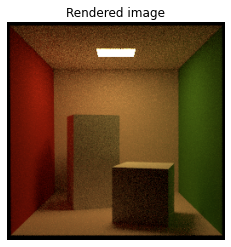

In [5]:
integrator = scene.integrator()
image = integrator.render(scene, spp=32)

def show_image(img, title):
    plt.imshow(convert_to_bitmap(img, crop_size)); plt.axis('off'); plt.title(title);
    
show_image(image, 'Rendered image')

The following line with assign unit gradient values to the reflectance parameter and forward-propagate through the computation graph representing the differentiable simulation.

In [6]:
ek.forward(reflectance_param)

It is then possible to query the resulting gradients propagated to the output image and visualize them as a gradient image.

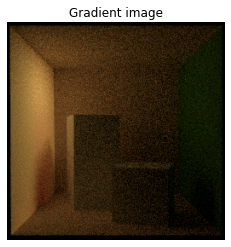

In [7]:
image_grad = ek.grad(image)
show_image(image_grad, 'Gradient image')

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)